# Assignment 6: Model Evaluation and Model Selection

### Objective: In this assignment, you will gain hands-on experience in evaluating the performance of machine learning models and selecting the best features for your model. The assignment will focus on the following concepts:

- Accuracy evaluation using cross-validation
- Confidence intervals for the accuracy or the error rate
- Hyperparameter tuning using grid search
- Evaluation metrics such as Precision, Recall, and F1-Score, ROC-AUC
- Feature selection methods: Filter methods, Embedded methods, and Wrapper methods
- Feature extraction methods, such as Principal Component Analysis (PCA)

### Dataset:

In this assignment we will use the "Bank Marketing" dataset. This dataset is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe to a term deposit (yes/no). 

The dataset contains 20 input features, such as age, job, marital status, education, and others. The target variable is imbalanced, with the majority of the clients not subscribing to the term deposit.

You can find the Bank Marketing dataset on the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/bank+marketing

For your convenience, the dataset has been dowloaded and can be found in the Data folder.

Notes:

duration input:

    this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Missing Attribute Values:

    There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques.

### Load the dataset into a Pandas dataframe and show the first five rows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
data_path = './Data/bank-additional.csv'
data = pd.DataFrame(pd.read_csv(data_path, sep = ';'))

#print(data.head(5))

### Preprocess the data

In [3]:
# Preprocess categorical features
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric_features = [col for col in data.columns if col not in categorical_features + ['y']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Split into features and targets
X = data.drop(columns=['y'])
y = data['y'].map({'no': 0, 'yes': 1})

# Preprocess the features
X = preprocessor.fit_transform(X)

# Get the column names for the one-hot encoded features
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)

# Combine the numeric and one-hot encoded feature names
all_feature_names = numeric_features + list(onehot_columns)

# Convert the transformed matrix X back into a DataFrame with the feature names. Pandas provides functions for explorarory data analysis.
X = pd.DataFrame(X, columns=all_feature_names)

print(X.head())

        age  duration  campaign     pdays  previous  emp.var.rate  \
0 -0.980752  0.903952 -0.209228  0.201031 -0.351356     -1.206054   
1 -0.107991  0.350300  0.569634  0.201031 -0.351356      0.649441   
2 -1.465619 -0.116966 -0.598660  0.201031 -0.351356      0.841389   
3 -0.204965 -0.941553  0.180203  0.201031 -0.351356      0.841389   
4  0.667795 -0.780563 -0.598660  0.201031 -0.351356     -0.118350   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month_oct  \
0       -1.185448      -1.240939  -1.331707    -0.914779  ...        0.0   
1        0.715193       0.892269   0.711698     0.332862  ...        0.0   
2        1.528273      -0.283172   0.773427     0.836535  ...        0.0   
3        1.528273      -0.283172   0.771697     0.836535  ...        0.0   
4       -0.655478      -0.326707   0.328632     0.398028  ...        0.0   

   month_sep  day_of_week_fri  day_of_week_mon  day_of_week_thu  \
0        0.0              1.0              0.0              0

### 3. Perform and Exploratory Data Analysis

1. Display a histogram of each feature so we can see the distribution of their values.
2. Use Seaborn to display a barplot of the correlation of each feature with the target variable.

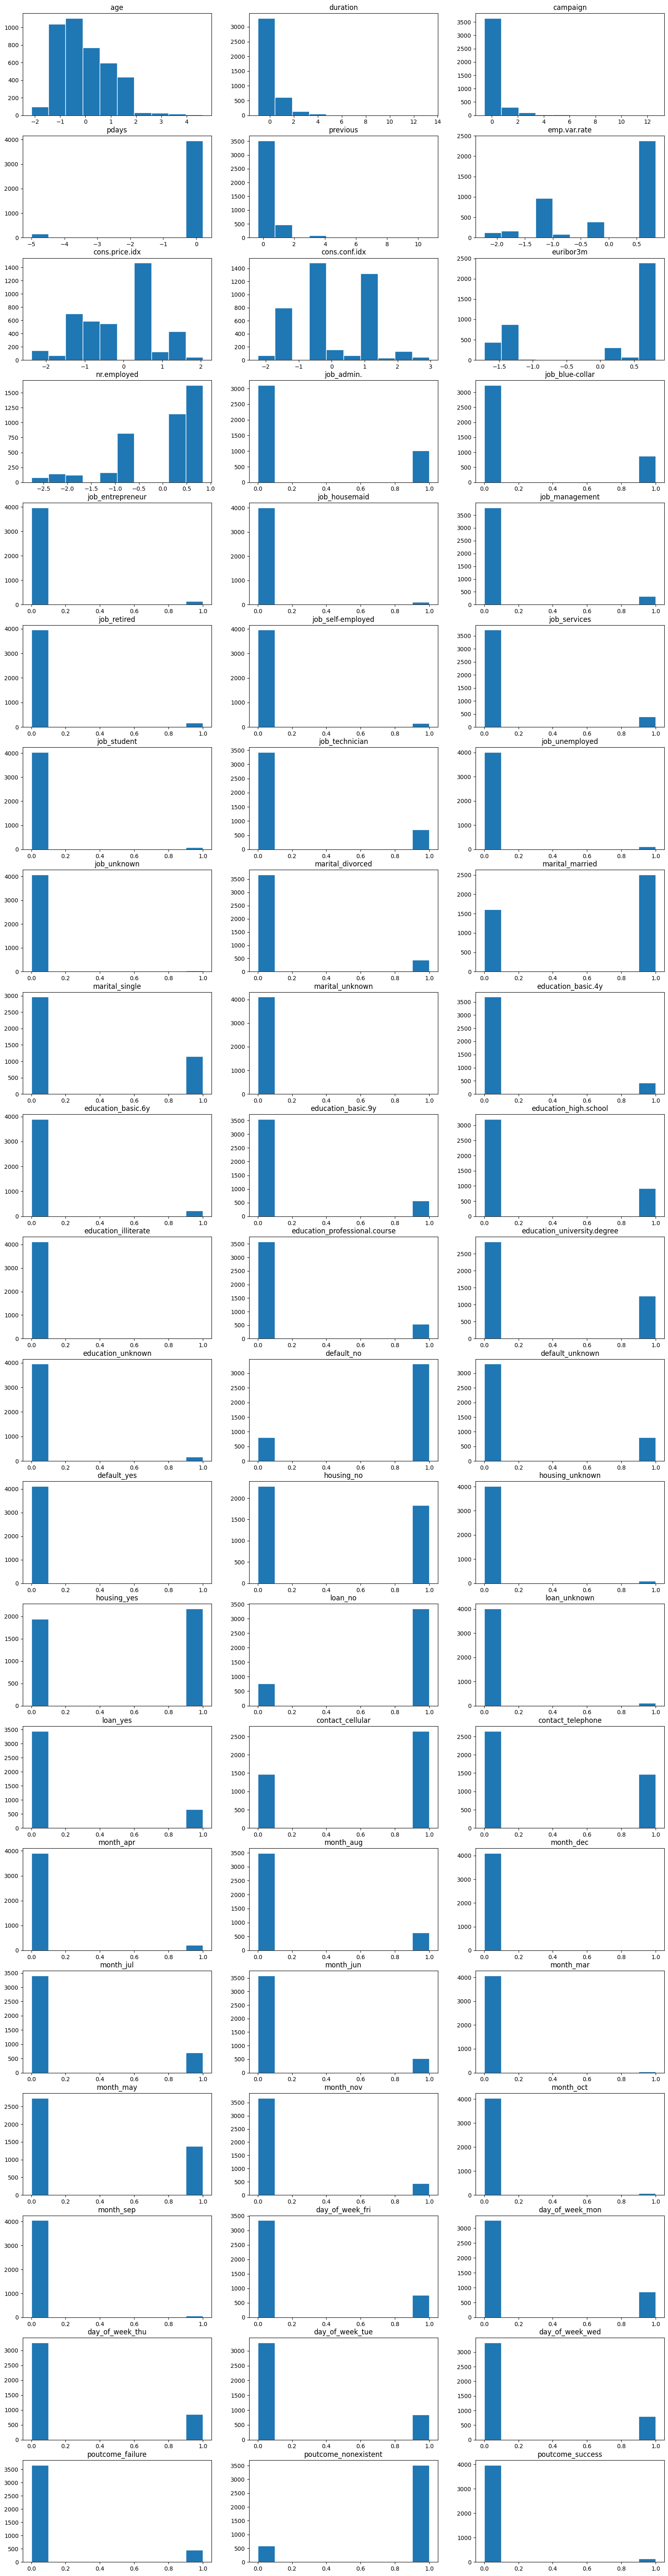

In [4]:
fig, axs = plt.subplots(nrows=21, ncols=3, figsize=(20,80))
axs = axs.flatten()
for i, col in enumerate(X.iloc[:, :63].columns):
    bins = np.histogram_bin_edges(X[col])
    axs[i].hist(X[col], bins=bins, edgecolor = 'w')
    axs[i].set_title(col)
plt.show()

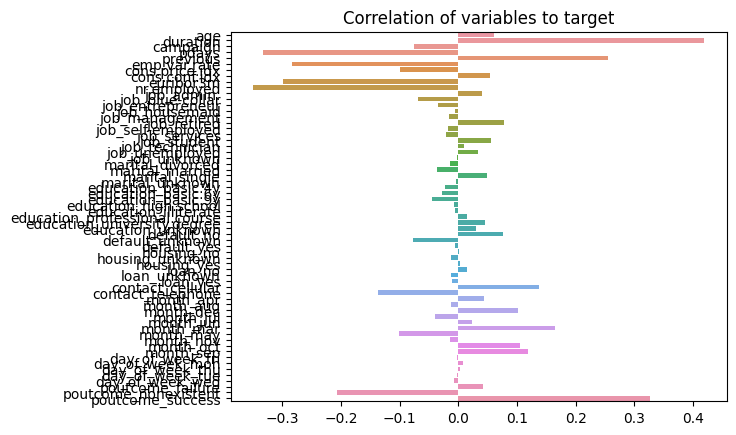

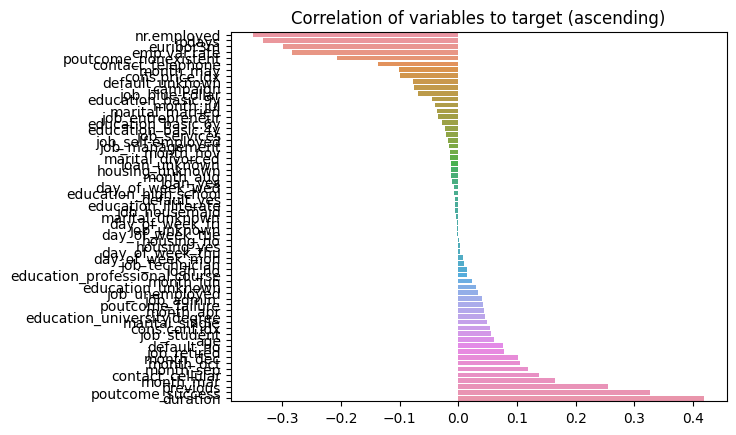

In [5]:
merged = X
merged['y'] = y
corr = merged[merged.columns].corr()['y']
corr = corr.drop(labels = ['y'])
sns.barplot(x=corr.values, y=corr.index)
plt.title('Correlation of variables to target')
plt.show()
corr_sorted = corr.sort_values(ascending=True)
sns.barplot(x=corr_sorted.values, y=corr_sorted.index)
plt.title('Correlation of variables to target (ascending)')
plt.show()
X = merged.drop('y', axis=1)

**What are your takeways from the exploratory data analysis?**

'duration' as stated in bank-additonal-names.txt is the strongest predictor of if the client subscribes.

'nr.employed' outside of 'duration' has the strongest (negative) correlation with 'y'.

'housing' has the weakest correlation with 'y', and in the case of 'housing_no' has, seemingly, zero correlation with 'y'.

'education' has minimal effect on 'y'. It is notable that lesser education (illiterate, 4y, 6y, 9y, highschool) is negatively correlated with 'y', and higher education (professional, university) and unknown education is positively correlated.

'day_of_the_week', 'loan', 'job' and 'marital' have little correlation with 'y'.
there is a strong positive correlation when 'contact' = cellular, and a strong negative correlation when 
'contact' = telephone

The effect of 'month' is varied but no month has a strong negative correlation with 'y'

In [6]:
#Removing 'duration' as suggested by bank-addional-names.txt
X = X.drop('duration', axis=1)

### 4. Split the data into a stratified 80/20 train/test split.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y) 

### 5. Apply feature selection

Use the following feature selection methods:
1. Filter: Variance Threshold with a threshold of 0.1
2. Embedded: Use the LASSO L1 penalty in the LogisticRegressionCV and keep the features with non-zero coefficients
3. Wrapper: Use Recursive Feature Elimination (RFECV) with Logistic Regression as the estimator.
4. Feature Extraction: Use PCA to extract the top 20 components

For the first three feature selection methods, print out the names of the features that were selected.

**Note:** Since this is an imbalanced dataset using the default scoring criterion, which is classification Accuracy, will not yield good results. For that reason, you should use the F1-Score (`scoring='f1'`) whenever you fit a classifier.

In [8]:
variance = VarianceThreshold(threshold=0.1)
X_train_variance = variance.fit_transform(X_train)
X_test_variance = variance.transform(X_test)
selected_variance = X_train.columns[variance.get_support()]
print("Features selected by Variance Threshold: ")
print(selected_variance)
print()

embedded = LogisticRegressionCV(penalty='l1', solver='liblinear', scoring='f1')
embedded.fit(X_train, y_train)
selected_embedded = X_train.columns[embedded.coef_[0] != 0].tolist()
X_train_embedded = X_train[selected_embedded]
X_test_embedded = X_test[selected_embedded]
print("Features selected by LASSO L1 penalty: ")
print(selected_embedded)
print()

estimator = LogisticRegression(max_iter=1000)
rfecv = RFECV(estimator, step=1, cv=5, scoring='f1')
rfecv.fit(X_train, y_train)
selected_rfecv = X_train.columns[rfecv.support_]
X_train_rfecv = X_train[selected_rfecv]
X_test_rfecv = X_test[selected_rfecv]
print("Features selected by RFECV: ")
print(selected_rfecv)
print()

pca = PCA(n_components=20)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)
##################################################################################
RF_variance = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_variance, y_train)
RF_variance.fit(X_train_variance, y_train)
y_pred_variance = RF_variance.predict(X_test_variance)
f1_variance = f1_score(y_test, y_pred_variance)
print("F1 Score for Variance Threshold: ", f1_variance)

y_pred_embedded = embedded.predict(X_test)
f1_embedded = f1_score(y_test, y_pred_embedded)
print("F1 Score for LASSO L1 penalty: ", f1_embedded)

LR_rfecv = LogisticRegression(max_iter=1000).fit(X_train_rfecv, y_train)
LR_rfecv.fit(X_train_rfecv, y_train)
y_pred_rfecv = LR_rfecv.predict(X_test_rfecv)
f1_rfecv = f1_score(y_test, y_pred_rfecv)
print("F1 Score for RFECV: ", f1_rfecv)

LR_PCA = LogisticRegression(max_iter=1000).fit(X_train_PCA, y_train)
y_pred_PCA = LR_PCA.predict(X_test_PCA)
f1_PCA = f1_score(y_test, y_pred_PCA)
print("F1 Score for PCA: ", f1_PCA)

Features selected by Variance Threshold: 
Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_technician', 'marital_married',
       'marital_single', 'education_basic.9y', 'education_high.school',
       'education_professional.course', 'education_university.degree',
       'default_no', 'default_unknown', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'month_aug',
       'month_jul', 'month_jun', 'month_may', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent'],
      dtype='object')

Features selected by LASSO L1 penalty: 
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', '

### 6. Fine Tune a Classification Algorithm

We will use the `GradientBoostingClassifier` which is know to be one of the most powefull ensemble algorithms. Some of the hyperparameters that can be tuned when training a GradientBoostingClassifier are:
- Number of estimators (trees): try 100, 200, 300
- Learning rate: try 0.01, 0.1
- Max (tree) depth: try 3, 4

Use `GridSearchCV` to train your classifier for the different hyperparameter values. Remember to use F1-score as your scoring criterion.

Tune your model on the features selected by each one of the methods above.

In [150]:
params = {'n_estimators':[100, 200, 300],
          'learning_rate':[.01, .1],
          'max_depth':[3, 4]}

grid_filter = GridSearchCV(GradientBoostingClassifier(), params, scoring='f1', cv=5)
grid_filter.fit(X_train_variance, y_train)
print("Variance Threshold Best Parameters: ", grid_filter.best_params_)
print("Variance Threshold F1 Score: ", grid_filter.best_score_)
print()

grid_embedded = GridSearchCV(GradientBoostingClassifier(), params, scoring='f1', cv=5)
grid_embedded.fit(X_train_embedded, y_train)
print("LASSO L1 Penalty Best Parameters: ", grid_embedded.best_params_)
print("LASSO L1 Penalty F1 Score: ", grid_embedded.best_score_)
print()

grid_RFECV = GridSearchCV(GradientBoostingClassifier(), params, scoring='f1', cv=5)
grid_RFECV.fit(X_train_rfecv, y_train)
print("RFECV Best Parameters: ", grid_RFECV.best_params_)
print("RFECV F1 Score: ", grid_RFECV.best_score_)
print()

grid_PCA = GridSearchCV(GradientBoostingClassifier(), params, scoring='f1', cv=5)
grid_PCA.fit(X_train_PCA, y_train)
print("PCA Best Parameters: ", grid_PCA.best_params_)
print("PCA F1 Score: ", grid_PCA.best_score_)
print()

Variance Threshold Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Variance Threshold F1 Score:  0.36178822789393184

LASSO L1 Penalty Best Parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
LASSO L1 Penalty F1 Score:  0.3645874853845817

RFECV Best Parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
RFECV F1 Score:  0.357810980199448

PCA Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
PCA F1 Score:  0.33712563035809656



### 7. Evaluate your tuned models on the test data

For each one of the tuned models, print out the following metrics:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC

For the model that produces the best f1-score, print out the confusion matrix and classification report using the skearn `classification_report` function.


In [155]:
print("Variance Threshold Model...")
print("Accuracy Score: {:.4f}".format(accuracy_score(y_test, y_pred_variance)))
print("Precision Score: {:.4f}".format(precision_score(y_test, y_pred_variance)))
print("Recall Score: {:.4f}".format(recall_score(y_test, y_pred_variance)))
print("F1-Score: {:.4f}".format(f1_variance))
print("ROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_pred_variance)))
print()

print("LASSO L1 Penalty Model...")
print("Accuracy Score: {:.4f}".format(accuracy_score(y_test, y_pred_embedded)))
print("Precision Score: {:.4f}".format(precision_score(y_test, y_pred_embedded)))
print("Recall Score: {:.4f}".format(recall_score(y_test, y_pred_embedded)))
print("F1-Score: {:.4f}".format(f1_embedded))
print("ROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_pred_embedded)))
print()

print("RFECV Model...")
print("Accuracy Score: {:.4f}".format(accuracy_score(y_test, y_pred_rfecv)))
print("Precision Score: {:.4f}".format(precision_score(y_test, y_pred_rfecv)))
print("Recall Score: {:.4f}".format(recall_score(y_test, y_pred_rfecv)))
print("F1-Score: {:.4f}".format(f1_rfecv))
print("ROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_pred_rfecv)))
print()

print("PCA Model...")
print("Accuracy Score: {:.4f}".format(accuracy_score(y_test, y_pred_PCA)))
print("Precision Score: {:.4f}".format(precision_score(y_test, y_pred_PCA)))
print("Recall Score: {:.4f}".format(recall_score(y_test, y_pred_PCA)))
print("F1-Score: {:.4f}".format(f1_PCA))
print("ROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_pred_PCA)))

Variance Threshold Model...
Accuracy Score: 0.8871
Precision Score: 0.4651
Recall Score: 0.2222
F1-Score: 0.3008
ROC-AUC Score: 0.5954

LASSO L1 Penalty Model...
Accuracy Score: 0.8944
Precision Score: 0.5484
Recall Score: 0.1889
F1-Score: 0.2810
ROC-AUC Score: 0.5849

RFECV Model...
Accuracy Score: 0.8944
Precision Score: 0.5484
Recall Score: 0.1889
F1-Score: 0.2810
ROC-AUC Score: 0.5849

PCA Model...
Accuracy Score: 0.9005
Precision Score: 0.6250
Recall Score: 0.2222
F1-Score: 0.3279
ROC-AUC Score: 0.6029


In [156]:
print("PCA Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_PCA))
print("PCA Classification Report:")
print(classification_report(y_test, y_pred_PCA))

PCA Confusion Matrix:
[[722  12]
 [ 70  20]]
PCA Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       734
           1       0.62      0.22      0.33        90

    accuracy                           0.90       824
   macro avg       0.77      0.60      0.64       824
weighted avg       0.88      0.90      0.88       824



### 8. Discuss your results

**What are your main takeaways from this assignment?**

While I'm sure I probably done something wrong (I'm very tired), it seems that a dataset that is heavily skewed toward one target variable value over the other produces poor predictive models.